### Overview
This Jupyter notebook can be used to retrieve the pitch data from [pybaseball](https://github.com/jldbc/pybaseball), export it as a csv, and also how to import the csv for future use.

#### Retrieveing the data

In [1]:
# Import necessary libraries
import pybaseball as pyb
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#### Importing the data
Only run these once you've either ran the above cells, or if you've downloaded and unzipped the file from [our GitHub](https://github.com/Erdos-Projects/fall-2025-sports-analytics)

In [2]:
df = pd.read_csv('all_september_2025_pitches.csv') [::-1] # reverse to get the order correct

In [3]:
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
109967,3924,FF,2025-09-01,98.6,-2.10,5.34,"Dollander, Chase",671218,801403,NaN,...,1.0,1.62,0.90,0.90,21.8,NaN,NaN,NaN,NaN,NaN
109966,3746,SI,2025-09-01,96.9,-2.11,5.30,"Dollander, Chase",671218,801403,field_out,...,1.0,2.09,1.34,1.34,20.2,2.725533,4.178553,22.526160,32.109508,23.069677
109965,3682,FF,2025-09-01,98.9,-1.97,5.39,"Dollander, Chase",646240,801403,NaN,...,1.0,1.18,1.13,-1.13,20.3,NaN,NaN,NaN,NaN,NaN
109964,3558,FF,2025-09-01,99.5,-2.20,5.32,"Dollander, Chase",646240,801403,NaN,...,1.0,1.32,0.98,-0.98,25.4,NaN,NaN,NaN,NaN,NaN
109963,3444,CH,2025-09-01,89.9,-2.16,5.15,"Dollander, Chase",646240,801403,NaN,...,1.0,2.43,1.46,-1.46,19.2,7.015982,6.855776,21.052232,46.184076,25.009321


In [4]:
# careful with what the variables mean. 'pitch_number' is within the plate appearance, as you can see here
df['pitch_number'][:10]

109967    1
109966    2
109965    1
109964    2
109963    3
109962    4
109961    1
109960    2
109959    3
109958    4
Name: pitch_number, dtype: int64

In [5]:
# Group by game and pitcher, then create a pitch count
df['pitch_count'] = df.groupby(['game_pk', 'pitcher']).cumcount() + 1


In [ ]:
# Filter to final pitch for each pitcher in each game
final_pitches = df[df['last_pitch_of_game']]

# Check a few rows
final_pitches[['game_pk', 'pitcher', 'pitch_count']].head()

In [6]:
# make the dataframe a little easier to deal with
keeper_columns = ['game_date','game_pk', 'release_speed', 'release_pos_x', 'release_pos_z', 'batter', 'pitcher','inning', 'inning_topbot', 'events', 'description','pitch_number','pitch_count']

df = df[keeper_columns]

In [7]:
# Create a boolean column: True if this is the last pitch by pitcher in game
df['last_pitch_of_game'] = df.groupby(['game_pk', 'pitcher'])['pitch_count'].transform('idxmax') == df.index


In [8]:
# number of pitching changes or end of game in September
sum(df['last_pitch_of_game'])

3330

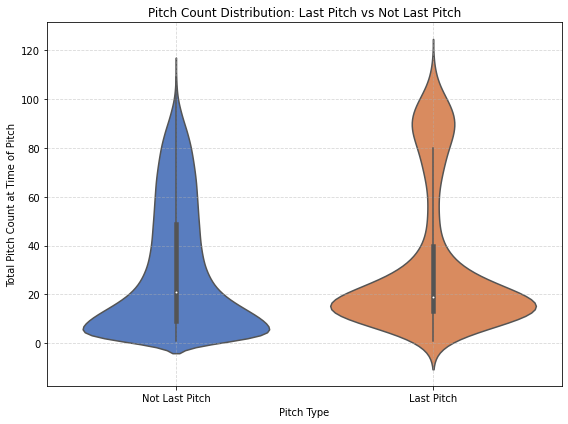

In [9]:
# Optional: Make labels more readable
df['is_last_pitch'] = df['last_pitch_of_game'].map({True: 'Last Pitch', False: 'Not Last Pitch'})

# Create violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='is_last_pitch', y='pitch_count', inner='box', palette='muted')

# Customize plot
plt.title('Pitch Count Distribution: Last Pitch vs Not Last Pitch')
plt.xlabel('Pitch Type')
plt.ylabel('Total Pitch Count at Time of Pitch')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [10]:
# Filter to final pitch for each pitcher in each game
final_pitches = df[df['last_pitch_of_game']]

# Check a few rows
final_pitches[['game_pk', 'pitcher', 'pitch_count']].head()


,game_pk,pitcher,pitch_count
109820,776492,801403,84
109776,776492,678906,85
109733,776492,666711,25
109716,776492,683627,58
109678,776492,669020,23


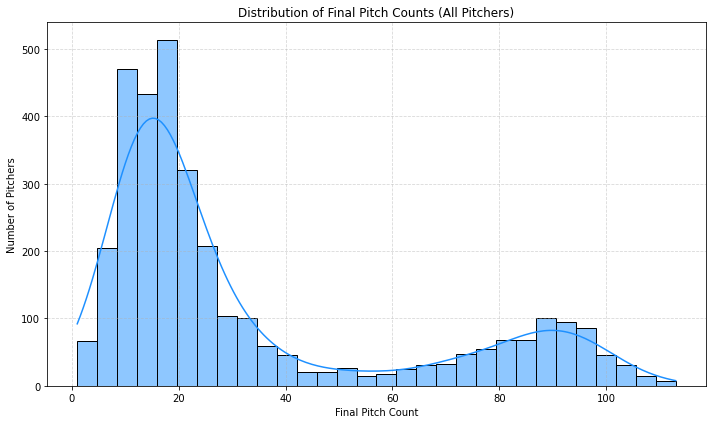

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(final_pitches['pitch_count'], bins=30, kde=True, color='dodgerblue')
plt.title('Distribution of Final Pitch Counts (All Pitchers)')
plt.xlabel('Final Pitch Count')
plt.ylabel('Number of Pitchers')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
# Step 1: Get the first pitch each pitcher threw in each game
first_pitch_per_pitcher = df.groupby(['game_pk', 'pitcher']).head(1)

# Step 2: Starters are those whose first pitch came in inning 1 (top or bottom)
# Warning, this line really takes anyone whose first pitch was in 1st inning and calls them a starter
# So if a starter has a meltdown and a reliever comes in in the 1st, this is still labeling the reliever a starter
starters = first_pitch_per_pitcher[first_pitch_per_pitcher['inning'] == 1]

# Step 3: Create starter ID pairs (game_pk, pitcher)
starter_ids = starters[['game_pk', 'pitcher']].drop_duplicates()

# Step 4: Label each row in the full DataFrame as 'starter' or 'reliever'
df = df.copy()  # avoid SettingWithCopyWarning
df['role'] = df[['game_pk', 'pitcher']].merge(
    starter_ids.assign(role='starter'),
    on=['game_pk', 'pitcher'],
    how='left'
)['role'].fillna('reliever')


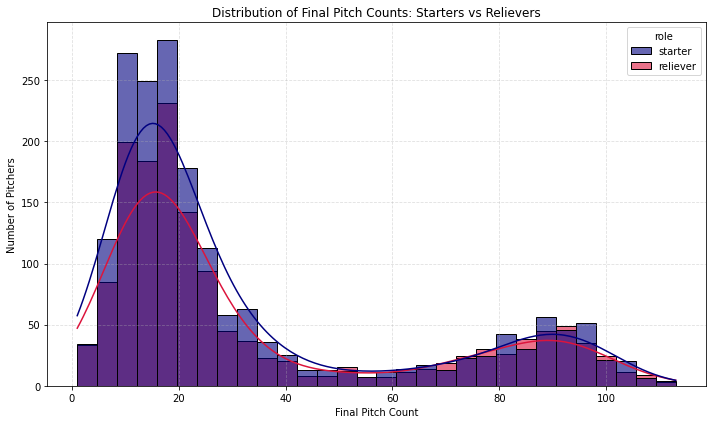

In [15]:
# Final pitches only
final_pitches = df[df['last_pitch_of_game']]

# Plot the distribution by role
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(
    data=final_pitches,
    x='pitch_count',
    hue='role',
    bins=30,
    kde=True,
    palette={'starter': 'navy', 'reliever': 'crimson'},
    alpha=0.6
)
plt.title('Distribution of Final Pitch Counts: Starters vs Relievers')
plt.xlabel('Final Pitch Count')
plt.ylabel('Number of Pitchers')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


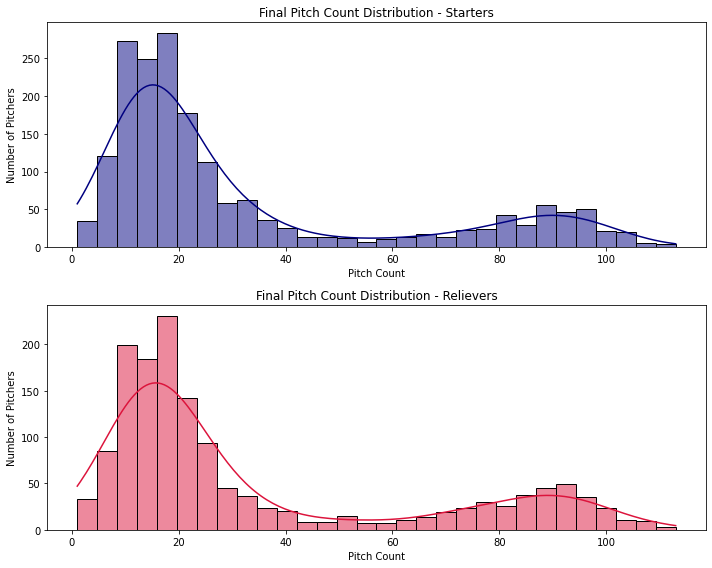

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Starter histogram
plt.subplot(2, 1, 1)
sns.histplot(final_pitches[final_pitches['role'] == 'starter']['pitch_count'], bins=30, color='navy', kde=True)
plt.title('Final Pitch Count Distribution - Starters')
plt.xlabel('Pitch Count')
plt.ylabel('Number of Pitchers')

# Reliever histogram
plt.subplot(2, 1, 2)
sns.histplot(final_pitches[final_pitches['role'] == 'reliever']['pitch_count'], bins=30, color='crimson', kde=True)
plt.title('Final Pitch Count Distribution - Relievers')
plt.xlabel('Pitch Count')
plt.ylabel('Number of Pitchers')

plt.tight_layout()
plt.show()


In [17]:
# Group by 'last_pitch_of_game' and calculate mean pitch count
mean_pitch_counts = df.groupby('last_pitch_of_game')['pitch_count'].mean()
print(mean_pitch_counts)


last_pitch_of_game
False    30.200276
True     33.023423
Name: pitch_count, dtype: float64


In [18]:
df.head()

,game_date,game_pk,release_speed,release_pos_x,release_pos_z,batter,pitcher,inning,inning_topbot,events,description,pitch_number,pitch_count,last_pitch_of_game,is_last_pitch,role
109967,2025-09-01,776492,98.6,-2.10,5.34,671218,801403,1,Top,NaN,called_strike,1,1,False,Not Last Pitch,reliever
109966,2025-09-01,776492,96.9,-2.11,5.30,671218,801403,1,Top,field_out,hit_into_play,2,2,False,Not Last Pitch,reliever
109965,2025-09-01,776492,98.9,-1.97,5.39,646240,801403,1,Top,NaN,ball,1,3,False,Not Last Pitch,reliever
109964,2025-09-01,776492,99.5,-2.20,5.32,646240,801403,1,Top,NaN,called_strike,2,4,False,Not Last Pitch,reliever
109963,2025-09-01,776492,89.9,-2.16,5.15,646240,801403,1,Top,NaN,foul,3,5,False,Not Last Pitch,reliever


The above section included pitchers who finished the game for their team. Those pitchers weren't ''pulled'' perse, so this section filters out those pitchers. It turns out to not have a huge effect on our visualizations.

In [19]:
# Step 1: Find the last pitch index for each game
last_pitch_in_game_idx = df.groupby('game_pk')['pitch_number'].idxmax()

# Step 2: Create a column to flag pitches that are the final pitch of the game
df['is_game_final_pitch'] = False
df.loc[last_pitch_in_game_idx, 'is_game_final_pitch'] = True

# Step 3: Exclude pitchers whose last pitch was the final pitch of the game
df_filtered = df[~((df['last_pitch_of_game']) & (df['is_game_final_pitch']))]


In [20]:
df_filtered.head()

,game_date,game_pk,release_speed,release_pos_x,release_pos_z,batter,pitcher,inning,inning_topbot,events,description,pitch_number,pitch_count,last_pitch_of_game,is_last_pitch,role,is_game_final_pitch
109967,2025-09-01,776492,98.6,-2.10,5.34,671218,801403,1,Top,NaN,called_strike,1,1,False,Not Last Pitch,reliever,False
109966,2025-09-01,776492,96.9,-2.11,5.30,671218,801403,1,Top,field_out,hit_into_play,2,2,False,Not Last Pitch,reliever,False
109965,2025-09-01,776492,98.9,-1.97,5.39,646240,801403,1,Top,NaN,ball,1,3,False,Not Last Pitch,reliever,False
109964,2025-09-01,776492,99.5,-2.20,5.32,646240,801403,1,Top,NaN,called_strike,2,4,False,Not Last Pitch,reliever,False
109963,2025-09-01,776492,89.9,-2.16,5.15,646240,801403,1,Top,NaN,foul,3,5,False,Not Last Pitch,reliever,False


<ipython-input-21-64da97cb7dd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_last_pitch'] = df_filtered['last_pitch_of_game'].map({True: 'Last Pitch', False: 'Not Last Pitch'})


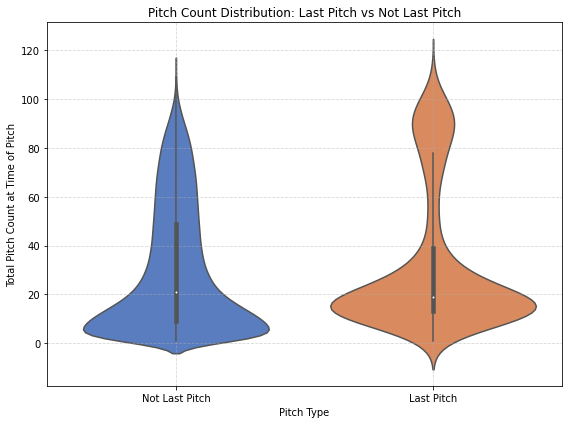

In [21]:
# Optional: Make labels more readable
df_filtered['is_last_pitch'] = df_filtered['last_pitch_of_game'].map({True: 'Last Pitch', False: 'Not Last Pitch'})

# Create violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_filtered, x='is_last_pitch', y='pitch_count', inner='box', palette='muted')

# Customize plot
plt.title('Pitch Count Distribution: Last Pitch vs Not Last Pitch')
plt.xlabel('Pitch Type')
plt.ylabel('Total Pitch Count at Time of Pitch')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


The visualization doesn't look that different, so I'm just going to use df and not df_filtered for now. Next, take just the starters and build a model for them.

In [22]:
# Step 1: Get the first pitch of each pitcher in each game
first_pitches = df.groupby(['game_pk', 'pitcher'])['pitch_number'].min().reset_index()

# Step 2: Merge it back to the main DataFrame to get the inning and inning_topbot of their first pitch
first_pitch_data = df.merge(first_pitches, on=['game_pk', 'pitcher', 'pitch_number'])

# Step 3: Starting pitchers throw the first pitch of the Top or Bottom of the 1st inning
# So filter for inning == 1
starter_ids = first_pitch_data[
    (first_pitch_data['inning'] == 1)
]['pitcher'].unique()

# Step 4: Filter the original DataFrame to include only those starters
df_starters = df[df['pitcher'].isin(starter_ids)]


<ipython-input-29-90077f8ac83b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starters['is_last_pitch'] = df_starters['last_pitch_of_game'].map({True: 'Last Pitch', False: 'Not Last Pitch'})


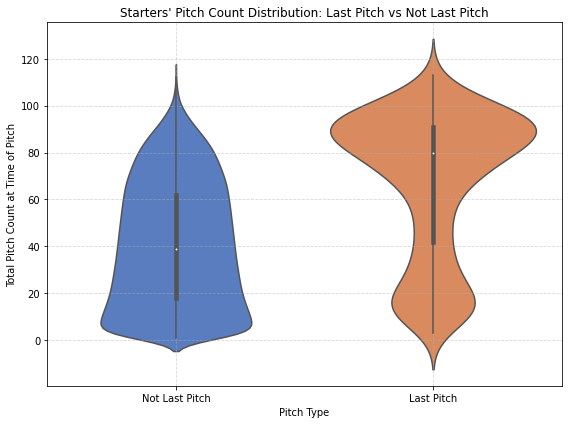

In [29]:
# Optional: Make labels more readable
df_starters['is_last_pitch'] = df_starters['last_pitch_of_game'].map({True: 'Last Pitch', False: 'Not Last Pitch'})

# Create violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_starters, x='is_last_pitch', y='pitch_count', inner='box', palette='muted')

# Customize plot
plt.title('Starters\' Pitch Count Distribution: Last Pitch vs Not Last Pitch')
plt.xlabel('Pitch Type')
plt.ylabel('Total Pitch Count at Time of Pitch')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [24]:
# Group by 'last_pitch_of_game' and calculate mean pitch count
mean_pitch_counts = df_starters.groupby('last_pitch_of_game')['pitch_count'].mean()
print(mean_pitch_counts)


last_pitch_of_game
False    40.918042
True     67.555992
Name: pitch_count, dtype: float64


In [25]:
# Make sure you have the clean starter-only dataset
df_model = df_starters.copy()

# Explanatory and response variables
X = df_model[['pitch_count']]
y = df_model['last_pitch_of_game'].astype(int)  # Convert boolean to 0/1

# Add intercept
X = sm.add_constant(X)

# Fit logistic regression
model = sm.Logit(y, X).fit()

# Summary of the model
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.069659
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:     last_pitch_of_game   No. Observations:                68772
Model:                          Logit   Df Residuals:                    68770
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.09598
Time:                        14:31:40   Log-Likelihood:                -4790.6
converged:                       True   LL-Null:                       -5299.2
Covariance Type:            nonrobust   LLR p-value:                3.244e-223
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.3883      0.097    -65.549      0.000      -6.579      -6.197
pitch_count     0.0400    

In [26]:
# Get odds ratios
odds_ratios = np.exp(model.params)
print(odds_ratios)


const          0.001681
pitch_count    1.040771
dtype: float64


In [27]:
# Data
X = df_model[['pitch_count']]
y = df_model['last_pitch_of_game'].astype(int)

# Fit model
logreg = LogisticRegression()
logreg.fit(X, y)

# Predict probabilities
y_pred_proba = logreg.predict_proba(X)[:, 1]

# AUC Score
auc = roc_auc_score(y, y_pred_proba)
print("AUC Score:", auc)


AUC Score: 0.749758885910679


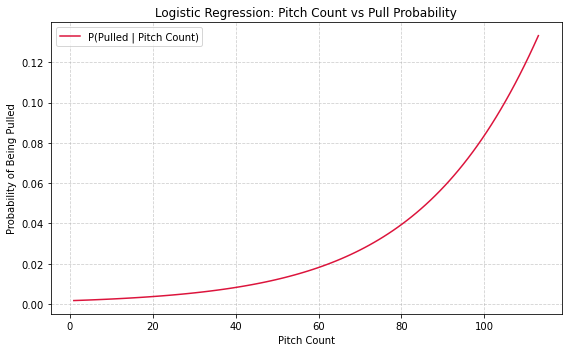

In [28]:
# Create pitch count range
pitch_range = np.linspace(df_model['pitch_count'].min(), df_model['pitch_count'].max(), 100).reshape(-1, 1)

# Predict probability of being pulled
prob_pull = logreg.predict_proba(pitch_range)[:, 1]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(pitch_range, prob_pull, label='P(Pulled | Pitch Count)', color='crimson')
plt.xlabel('Pitch Count')
plt.ylabel('Probability of Being Pulled')
plt.title('Logistic Regression: Pitch Count vs Pull Probability')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
